In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_244997/3459056358.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()


In [ ]:
tokens = np.unique(list(' '.join(lines)))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


In [ ]:
token_to_id = {tokens : i for i, tokens in enumerate(tokens)}

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [6]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [ ]:
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(token_to_id)

print(to_matrix(dummy_lines))



{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '<': 29, '=': 30, '>': 31, '?': 32, '@': 33, 'A': 34, 'B': 35, 'C': 36, 'D': 37, 'E': 38, 'F': 39, 'G': 40, 'H': 41, 'I': 42, 'J': 43, 'K': 44, 'L': 45, 'M': 46, 'N': 47, 'O': 48, 'P': 49, 'Q': 50, 'R': 51, 'S': 52, 'T': 53, 'U': 54, 'V': 55, 'W': 56, 'X': 57, 'Y': 58, 'Z': 59, '[': 60, '\\': 61, ']': 62, '^': 63, '_': 64, '`': 65, 'a': 66, 'b': 67, 'c': 68, 'd': 69, 'e': 70, 'f': 71, 'g': 72, 'h': 73, 'i': 74, 'j': 75, 'k': 76, 'l': 77, 'm': 78, 'n': 79, 'o': 80, 'p': 81, 'q': 82, 'r': 83, 's': 84, 't': 85, 'u': 86, 'v': 87, 'w': 88, 'x': 89, 'y': 90, 'z': 91, '{': 92, '|': 93, '}': 94, '~': 95, '\x7f': 96, '°': 97, 'É': 98, 'Ö': 99, 'Ü': 100, 'à': 101, 'á': 102, 'â': 103, 'ã': 104, 'ä': 105, 'æ': 106, 'ç': 107, 'è': 108, 'é': 109, 'ê':

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        """
        super().__init__() 
                
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.pad = nn.ZeroPad2d((4, 0, 0, 0))
        self.conv = nn.Conv1d(emb_size, hid_size, kernel_size=5)
        self.fc = nn.Linear(hid_size, n_tokens)
            
    def __call__(self, input_ix):

        pad = self.pad(input_ix)
        emb = self.emb(pad)
        emb = emb.permute((0, 2, 1))
        conv = self.conv(emb)
        conv = conv.permute((0, 2, 1))
        lin = self.fc(conv)


        return lin 
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy() 
        return dict(zip(tokens, probs))
        

In [10]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'fc.weight', 'fc.bias')


In [ ]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [ ]:
def compute_loss(model, input_ix):
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    mask = (reference_answers != 0).float()
    loss = F.cross_entropy(logits.permute(0, 2, 1), reference_answers, reduction='none')
    loss = torch.sum(loss * mask) / torch.sum(mask)
    
    return loss   

    

In [ ]:
def score_lines(model, dev_lines, batch_size):
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):

    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel()
opt = torch.optim.Adam(model.parameters())

dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingωóõśBαÜγ+4ê'γ1â°èÖêáj[α?αnχó!\αlγwωλ>S<@AX-ő]HEΩ8.áλ%|xαβnIx-χ|Uś{u*



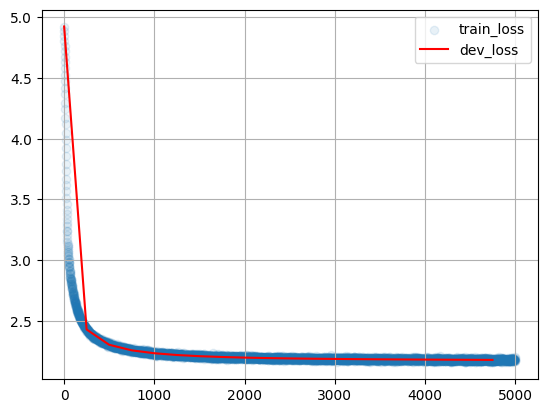

Generated examples (tau=0.5):
 Evale bution th the tho the manta. The mathis pederacinfor the s and opelsinge probleale gesere coms
 Dere teperon thing as en tha d the s ancensing as an ration the sere for antron sed lane wo ke pater
 Inturis comation, whe destion and sem of ce pore cog as of the berecon anden seate contion able deat
Scoring dev...


100%|██████████| 5000/5000 [26:15<00:00,  3.17it/s]

#4999 Dev loss: 2.178


In [18]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [19]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 2.1777856057329874
 Montion ar pored ing arksen balions ; The se thation ; We phe panil ion licr astice for tion a tha d
 A porectimat of the mons are che ares romals inathing ore the tale ropprexant arale exprobes (SDerat
 A Constin tadel arning int an us practing tien for ungerand imalion ming ; Ane raperes, we propencod
 A Spares inge proved ablend aperes the sere ly phove torimation A Derine seand tive textion sing tha
 Ches des ared forment oract senture of om wha d parem aning and cons and converiticasind at enture p
 Aning ar ing e male toon, the he seathien ing of ches and male for are chatextion inguag of ch buthe
 A peres co work of che unctres in ardestof th iont an inge pante s and se aper, we de ne the tome to
 Derins wiof chive in porstecomprica nonle reend tome ton ulation ; Intiming as we wha d Semplotin ta
 Inture that in thon thatice tod ang as of omethis monticl oreprive taplical inge perection ; The thi
 Pare nos mate the works (sion the precons ans 

In [ ]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):

        super().__init__()
        
        self.embedding =  nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, hid_size, batch_first=True)
        self.fc = nn.Linear(hid_size, n_tokens)
    
    def __call__(self, input_ix):

        embedded = self.embedding(input_ix)
        rnn, (hidden, cell) = self.rnn(embedded)
        fc = self.fc(rnn)
        
        return fc
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy() 
        return dict(zip(tokens, probs))
        

In [ ]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('embedding.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'fc.weight', 'fc.bias')


In [ ]:
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)


In [ ]:
batch_size = 128       
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel()
opt = torch.optim.Adam(model.parameters())

dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

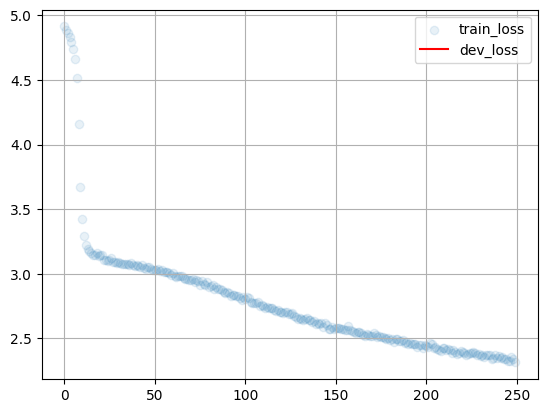

Generated examples (tau=0.5):
 Lh and mesting and the the penglees to pare ald Ber and of deconining or and on for the estistimed a
 WMontition and tioss soro mation the moper on this whe prontront dale the ingeralis of prached of se
 CSeration ard pare ande the intwirnation an that presers an on the pererisuling fors poning an tor t
Scoring dev...


  5%|▌         | 250/5000 [07:07<16:16:41, 12.34s/it]

#249 Dev loss: 2.330


  6%|▌         | 294/5000 [12:41<87:40:24, 67.07s/it]

In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    
    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))